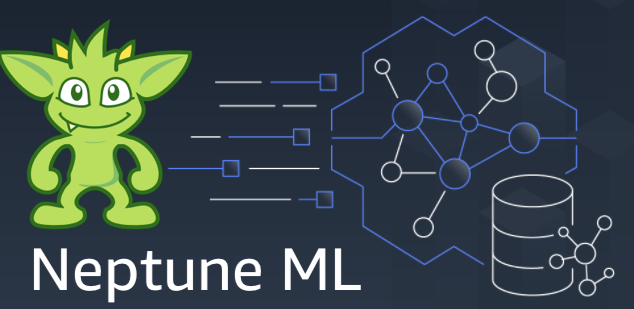

# Predict fraudulent providers in Medicare using Neptune ML
RUN in Sagemaker Notebooks (not Studio): This notebook uses the medicare datasets provided by CMS. In this Notebook  we'll walk through how Neptune ML can predict identification of fraudulent providers. To demonstrate this we'll predict the "Fraud" property of providers. We'll walk through each step of loading and exporting the data, configuring and training the model, and finally we'll show how to use that model to infer Fraud using Gremlin traversals.

## If Neptune has not been setup, please run the cloudformation script from the link below
https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-quick-start.html

## Checking that we are ready to run Neptune ML 
Run the code below to check that this cluster is configured to run Neptune ML.

In [ ]:
!pip install sagemaker
!pip install neptune_ml_utils

In [ ]:
import neptune_ml_utils as neptune_ml
import sagemaker

neptune_ml.check_ml_enabled()

Get the endpoint of the Neptune Cluster

In [ ]:
cluster_endpoint= neptune_ml.get_host() + ":8182"

## Please check that service limits of the following are available. If not, pls raise a ticket with AWS Support

ml.r5.xlarge for endpoint usage - 2
ml.p3.2xlarge for training job usage - 2
ml.r5.large for processing job usage - 2


## Delete existing graph

In [ ]:
%%gremlin
g.V().drop()

## Ensure you saved the "vertex_input.csv" and "edge_input.csv" files in S3  


## Load the nodes

Create an IAM role that provides full access to Amazon Neptune and Amazon S3 as indicated in the instructions below
https://docs.aws.amazon.com/neptune/latest/userguide/bulk-load-tutorial-IAM.html#bulk-load-tutorial-IAM-CreateRole

In [ ]:
s3_nodes_uri = "REPLACE WITH THE S3URI WHERE VERTEX_INPUT.CSV HAS BEEN UPLOADED"
load_role = "REPLACE WITH ARN OF IAM ROLE FROM ABOVE"
region = sagemaker.Session().boto_region_name

In [ ]:
import requests
url = 'https://{0}/loader'.format(cluster_endpoint)
headers = {'Content-Type': 'application/json'}
data = {
    'source': s3_nodes_uri,
    'format': 'csv',
    'iamRoleArn': load_role,
    'region': region,
    'failOnError': 'true',
    'parallelism': 'MEDIUM',
    'updateSingleCardinalityProperties': 'FALSE',
    'queueRequest': 'TRUE'
}

response = requests.post(url, headers=headers, json=data)
print("Status Code", response.status_code)
print("JSON Response ", response.json())

Check to see if the load is complete - you should have a status 200 for a succesful execution.

## Load the edges

In [ ]:
s3_edges_uri = "REPLACE WITH S3 URI WHERE EDGE_INPUT.CSV HAS BEEN UPLOADED"

In [ ]:
url = 'https://{0}/loader'.format(cluster_endpoint)
headers = {'Content-Type': 'application/json'}
data = {
    'source': s3_edges_uri,
    'format': 'csv',
    'iamRoleArn': load_role,
    'region': region,
    'failOnError': 'true',
    'parallelism': 'MEDIUM',
    'updateSingleCardinalityProperties': 'FALSE',
    'queueRequest': 'TRUE'
}

response = requests.post(url, headers=headers, json=data)
print("Status Code", response.status_code)
print("JSON Response ", response.json())

Check to see if the load is complete - you should have a status 200 for a succesful execution.

Provide an S3 bucket to store outputs of the data export job needed to train the model in SageMaker

In [ ]:
s3_bucket_uri="REPLACE WITH S3URI OF OUTPUT BUCKET"

Check to make sure the data is loaded

In [ ]:
%%gremlin
g.V().groupCount().by(label).unfold().order().by(keys)

If our nodes loaded correctly then the output is:

* 1084 Drugs
* 1836 HCPCS code
* 5983 Providers 

To check that our edges loaded correctly we check the edge counts:

In [ ]:
%%gremlin
g.E().groupCount().by(label).unfold().order().by(keys)

If our edges loaded correctly then the output is:

* 57807 conducts_procedure
* 62193 prescribes_drug


## Prepare data for Training - This data is used for training the model in Sagemaker 
First, let's simulate new providers being added into our product knowledge graph by randomly removing the `fraud` property from 1% of all  fraudulent providers (approx. 55)  nodes.  

In [ ]:
%%gremlin 
g.V().has('Provider', 'Fraud', 'YES').properties('Fraud').sample(55).drop()

Let's store these nodes to a variable "test_fraud"

In [ ]:
%%gremlin --store-to test_fraud
g.V().hasLabel('Provider').hasNot('Fraud').valueMap('NPI')

Let's also randomly removing the `fraud` property from a few  non-fraudulent providers (approx. 55)  nodes.  

In [ ]:
%%gremlin 
g.V().has('Provider', 'Fraud', 'NO').properties('Fraud').sample(55).drop()

Lets store all the simulated "new" nodes  to a variable "test_all"

In [ ]:
%%gremlin --store-to test_all
g.V().hasLabel('Provider').hasNot('Fraud').valueMap('NPI', 'Fraud')

Now lets prepare a pandas dataframes test_df that contains information on which of the simulated "new" nodes are classified as fraud versus. This will be necessary to evaluate the performance of our model

In [ ]:
import pandas as pd
test_fraud = pd.DataFrame.from_dict(test_fraud,dtype='string')
test_fraud['Fraud'] = 'YES'
test_all = pd.DataFrame.from_dict(test_all,dtype='string')
test_all['NPI'] = test_all['NPI'].str.replace(']','', regex=True)
test_all['NPI'] = test_all['NPI'].str.replace('[','', regex=True)
test_fraud['NPI'] = test_fraud['NPI'].str.replace(']','', regex=True)
test_fraud['NPI'] = test_fraud['NPI'].str.replace('[','', regex=True)
test_df = test_all.merge(test_fraud,on='NPI',how = 'left')
test_df = test_df.fillna('NO')

In [ ]:
test_df['Fraud'].value_counts()

Lets pick one of the providers

 Double check if the providers in test_df no longer have `Fraud` values by picking a value randomly and using the query below 

In [ ]:
NPI = test_df['NPI'].head(1).to_string(index=False)

In [ ]:
NPI

Query the graph using the above NPI 

In [ ]:
%%gremlin

g.V().has('Provider', 'NPI', ${NPI}).valueMap('NPI','Fraud')

# With these properties removed we're ready to build our Neptune ML Node Classification model to predict the Fraud indicator for these providers in our provider knowledge graph.  


# Export the data and model configuration

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: Before exporting data ensure that Neptune Export has been configured as described here: <a href="https://docs.aws.amazon.com/neptune/latest/userguide/export-service.html">Neptune Export Service</a></div>

The export process is triggered by calling to the [Neptune Export service endpoint](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-data-export-service.html).  
The configuration options provided to the export service are broken into two main sections, selecting the target and configuring features. 

## Selecting the target

In the first section, selecting the target, we specify what type of machine learning task will be run, and in the case of node classification, what the target node label and property we want to predict.  To run a node classification task we are only required to specify the node label and target property to infer. 

In this example below we specify the `Fraud` property on the `Provider` node as our target for prediction by including these values in the `targets` sub-parameter of the `additionalParams` object as shown below. 

```
"additionalParams": {
        "neptune_ml": {
          "targets": [
            {
              "node": "Provider",
              "property": "Fraud"
            }
          ],
          ....
```

## Configuring features
The second section of the configuration, configuring features, is where we specify details about the types of data stored in our graph and how the machine learning model should interpret that data.  
When data is exported from Neptune all properties of all nodes are included.  Each property is treated as a separate feature for the ML model.  Neptune ML does its best to infer the correct type of feature for a property, in many cases, the accuracy of the model can be improved by specifying information about the property used for a feature.  By default Neptune ML puts features into one of two categories:

* If the feature represents a numerical property (float, double, int) then it is treated as a `numerical` feature type. In this feature type data is represented as a continuous set of numbers.  For example, 'total_claim_count_mean'
* All other property types are represented as `category` features.  In this feature type, each unique value of data is represented as a unique value in the set of classifications used by the model. For our data, we have already one-hot encoded the only category feature "Female". 

If all of the properties fit into these two feature types then no configuration changes are needed at the time of export. However, in many scenarios these defaults are not always the best choice. In these cases, additional configuration options should be specified to better define how the property should be represented as a feature. For example, to handle text in the field, we could use techniques such as Word2vec from natural language processing to create a vector of data that represents a string of text.. 


Running the cell below we set the export configuration and run the export process.  Neptune export is capable of automatically creating a clone of the cluster by setting `cloneCluster=True` which takes about 20 minutes to complete and will incur additional costs while the cloned cluster is running.  Exporting from the existing cluster takes about 5 minutes but requires that the `neptune_query_timeout` parameter in the [parameter group](https://docs.aws.amazon.com/neptune/latest/userguide/parameters.html) is set to a large enough value (>72000) to prevent timeout errors.

In [ ]:
export_params={ 
"command": "export-pg", 
"params": { "endpoint": neptune_ml.get_host(),
            "profile": "neptune_ml",
            "useIamAuth": neptune_ml.get_iam(),
            "cloneCluster": False
            }, 
"outputS3Path": f'{s3_bucket_uri}/neptune-export',
"additionalParams": {
        "neptune_ml": {
          "version": "v2.0",
          "split_rate": [0.7,0.1,0.2],
          "targets": [
            {
              "node": "Provider",
              "property": "Fraud",
              "type": "classification"
            }
          ]
        }
      },
"jobSize": "medium"}

In [ ]:
%%neptune_ml export start --export-url {neptune_ml.get_export_service_host()} --export-iam --wait --store-to export_results
${export_params}

# ML data processing, model training, and endpoint creation

Once the export job is completed we are now ready to train our machine learning model and create the inference endpoint. Training our Neptune ML model requires three steps.  
  
<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: The cells below only configure a minimal set of parameters required to run a model training.</div>

## Data processing 
The first step (data processing) processes the exported graph dataset using standard feature preprocessing techniques to prepare it for use by DGL. This step performs functions such as feature normalization for numeric data and encoding text features using word2vec. At the conclusion of this step the dataset is formatted for model training. 

This step is implemented using a SageMaker Processing Job and data artifacts are stored in a pre-specified S3 location once the job is complete.

Additional options and configuration parameters for the data processing job can be found using the links below:

* [Data Processing](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-on-graphs-processing.html)
* [dataprocessing command](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-api-dataprocessing.html)

Run the cells below to create the data processing configuration and to begin the processing job.

In [ ]:
# The training_job_name can be set to a unique value below, otherwise one will be auto generated
training_job_name=neptune_ml.get_training_job_name('node-classification')

processing_params = f"""
--config-file-name training-data-configuration.json
--job-id {training_job_name} 
--s3-input-uri {export_results['outputS3Uri']} 
--s3-processed-uri {str(s3_bucket_uri)}/preloading """

In [ ]:
%neptune_ml dataprocessing start --wait --store-to processing_results {processing_params}

## Model training
The second step (model training) trains the ML model that will be used for predictions. The model training is done in two stages. The first stage uses a SageMaker Processing job to generate a model training strategy. A model training strategy is a configuration set that specifies what type of model and model hyperparameter ranges will be used for the model training. Once the first stage is complete, the SageMaker Processing job launches a SageMaker Hyperparameter tuning job. The SageMaker Hyperparameter tuning job runs a pre-specified number of model training job trials on the processed data, and stores the model artifacts generated by the training in the output S3 location. Once all the training jobs are complete, the Hyperparameter tuning job also notes the training job that produced the best performing model.

Additional options and configuration parameters for the data processing job can be found using the links below:

* [Model Training](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-on-graphs-model-training.html)
* [modeltraining command](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-api-modeltraining.html)

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Information</b>: The model training process takes ~20 minutes</div>

In [ ]:
training_params=f"""
--job-id {training_job_name}-1
--data-processing-id {training_job_name}
--instance-type ml.p3.2xlarge
--s3-output-uri {str(s3_bucket_uri)}/training
--max-hpo-number 2
--max-hpo-parallel 2 """

In [ ]:
%neptune_ml training start --wait --store-to training_results {training_params}

## Endpoint creation

The final step is to create the inference endpoint which is an Amazon SageMaker endpoint instance that is launched with the model artifacts produced by the best training job. This endpoint will be used by our graph queries to  return the model predictions for the inputs in the request. The endpoint once created stays active until it is manually deleted. Each model is tied to a single endpoint.

Additional options and configuration parameters for the data processing job can be found using the links below:

* [Inference Endpoint](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-on-graphs-inference-endpoint.html)
* [Endpoint command](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-api-endpoints.html)

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Information</b>: The endpoint creation process takes ~5-10 minutes</div>

In [ ]:
endpoint_params=f"""
--id {training_job_name}
--model-training-job-id {training_job_name} """

In [ ]:
%neptune_ml endpoint create --wait --store-to endpoint_results {endpoint_params}

Once this has completed we get the endpoint name for our newly created inference endpoint.  The cell below will set the endpoint name which will be used in the Gremlin queries below. 

In [ ]:
endpoint=endpoint_results['endpoint']['name']

In [ ]:
endpoint

# Predicting Fraud using Gremlin queries

Now that we have our inference endpoint setup let's query our provider knowledge graph to predict Fraud indicators for the providers that we updated earlier.  

Lets predict the Fraud indicator for `1003809195`.  To accomplish this we need to add two steps:

- First, we add the `with()` step to specify the inference endpoint we want to use with our Gremlin query like this
`g.with("Neptune#ml.endpoint","<INSERT ENDPOINT NAME>")`.  

<div style="background-color:#eeeeee; padding:10px; text-align:left; border-radius:10px; margin-top:10px; margin-bottom:10px; "><b>Note</b>: The endpoint values are automatically passed into the queries below</div>

- Second, when we ask for the property within our query we use the `properties()` step with an additional `with()` step (`with("Neptune#ml.classification")`) which specifies that we want to retrieve the predicted value for this property.

Putting these items together we get the query below, which will predict `Fraud` for the same provider we checked earlier 

In [ ]:
%%gremlin
g.with("Neptune#ml.endpoint", '${endpoint}').
  V().has('NPI', ${NPI}).properties('Fraud').with("Neptune#ml.classification").value()


## Comparing the accuracy of predicted and actual genres

First, lets predict the Fraud indicator for all providers without a `fraud` attribute and store the results in a variable called "results"

In [ ]:
%%gremlin --store-to results
g.with("Neptune#ml.endpoint","${endpoint}").
    V().hasLabel('Provider').hasNot('Fraud').
    project('NPI', 'predicted').
        by('NPI').
        by( properties("Fraud").with("Neptune#ml.classification").value()).
    order(local).by(keys, desc)

Prepare a dataframe results that stores the predicted as well as the original values

In [ ]:
results = pd.DataFrame.from_dict(results,dtype='string')
results = results.merge(test_df,on='NPI',how = 'inner')
results['predicted'] = results['predicted'].astype('str')
results = pd.get_dummies(results, drop_first = True )
results

Store the results in arrays that we will use to prepare confusion matrix and a classification report

In [ ]:
y_preds = results.predicted_YES.values.astype('float32')

In [ ]:
y_true = results.Fraud_YES.values.astype('float32')

Install seaborn and sklearn libraries that are needed for preparing the confusion matrix and a classification report

In [ ]:
!pip install seaborn

In [ ]:
!pip install sklearn

Import necessary libraries

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

Create confusion matrix and classification report

In [ ]:
def plot_confusion_matrix(y_true, y_predicted):

    cm  = confusion_matrix(y_true, y_predicted)
    # Get the per-class normalized value for each cell
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # We color each cell according to its normalized value, annotate with exact counts.
    ax = sns.heatmap(cm_norm, annot=cm, fmt="d")
    ax.set(xticklabels=["non-fraud", "fraud"], yticklabels=["non-fraud", "fraud"])
    ax.set_ylim([0,2])
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()

In [ ]:
print("Balanced accuracy = {:.3f}".format(balanced_accuracy_score(y_true, y_preds)))

In [ ]:
plot_confusion_matrix(y_true, y_preds)

In [ ]:
print(classification_report(
    y_true, y_preds, target_names=['non-fraud', 'fraud']))

Comparing the `original` versus the `predicted` results we see that our model did a good job of predicting whether the provider is fraudulent (46 out of 55) while also minimizing the number of falsely classified as fraud (3 out of 55)

# Cleaning up 
Now that you have completed this walkthrough you have created a Sagemaker endpoint which is currently running and will incur the standard charges.  If you are done trying out Neptune ML and would like to avoid these recurring costs, run the cell below to delete the inference endpoint.


In [ ]:
neptune_ml.delete_endpoint(training_job_name)

In addition to the inference endpoint the CloudFormation script that you used has setup several additional resources.  If you are finished then we suggest you delete the CloudFormation stack to avoid any recurring charges. For instructions, see Deleting a Stack on the [Deleting a Stack on the Amazon Web Services CloudFormation Console](https://docs.aws.amazon.com/AWSCloudFormation/latest/UserGuide/cfn-console-delete-stack.html). Be sure to delete the root stack (the stack you created earlier). Deleting the root stack deletes any nested stacks.